# Deep Learning: common issues and solutions

This notebook presenting various techniques must be handed in. It will be marked.
You must add your own comments and tests. It is the comments and your own tests that will be assessed.
* Commentary when comparing different approaches
* Own test, when testing different parameters

In [120]:
import pandas as pd
import numpy as np
import re
import string

In [121]:
import matplotlib.pyplot as plt

In [122]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [123]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model 

In [124]:
print(tf.__version__)

2.9.2


In [125]:
# !pip install keras-tuner --upgrade
import keras_tuner

In [126]:
### Some global constant
epochs=100
batch_size=256
patience=10
hidden_dim=256

In [127]:
### Usual function for babysit the network

# It is important to systematically observe the learning curves
def babysit(history):
    keys = [key for key in history.history.keys() if key[:4] != "val_"]
    fig, ax = plt.subplots(nrows=1, ncols=len(keys), figsize=(18, 5))
    for i, key in enumerate(keys):
        ax[i].plot(history.history[key], label=key)
        if "val_"+key in history.history.keys():
            ax[i].plot(history.history["val_"+key], label="val_"+key)
        ax[i].legend()
        ax[i].set_title(key)
    plt.show()

In [128]:
### Usual callback for training deep learning model

# It is important to use early stopping systematically
callbacks_list = [EarlyStopping(monitor='val_accuracy', mode='max',
                                patience=patience,
                                restore_best_weights=True)]

## 1. Today lab

In this lab we use part of the 'Amazon_Unlocked_Mobile.csv' dataset published by Kaggle. The dataset contain the following information:
* Product Name
* Brand Name
* Price
* Rating
* Reviews
* Review Votes

We are mainly interested by the 'Reviews' (X) and by the 'Rating' (y)

As you did in the previous lab, the goal is to try to predict the 'Rating' after reading the 'Reviews'.
We will mostly use this dataset as a case study to illustrate issues that you can have using Multilayer Perceptron or other Deep Learning architectures, namely:

1) **Text preprocessing with Tensorflow API**

2) **The vanishing gradient problem**:

Problem: Your model does not learn at all !
    
3) **Underfitting and Overfitting problems**
Problems:

    - Underfitting relates to the fact that your model does not learn enough on the train dataset to hope for good generalization abilities (good label prediction on new samples with unknown labels).
    - Overfitting means that your model fits too much to the train dataset, which can also prevents it from generalizing well to new samples with unknown labels.
    
4) **Starting, stopping, and resuming training**

Learning how to start, stop and resume learning a deep learning model is a very important skill to master. At some point:

* You have limited time on a GPU instance (this can happen on Google Colab or when using the cheaper Amazon EC2 point instances).
* Your SSH connection is broken.
* Your deep learning platform crashes and shuts down.

Imagine you've spent a whole week training a state-of-the-art deep neural network... and your model is lost due to a power failure! 

5) Find best hyper-parameters with keras-tuner

## 2. Dataset pre-processing

In this lab, we will just re-use the dataset of previous lab providing Sentiment Analysis tasks. 
And we will stick to the tf-idf approach for word embeddings. 

### a) Essential reminder [About Train, validation and test sets](https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7)
![test/train/val](https://miro.medium.com/max/1466/1*aNPC1ifHN2WydKHyEZYENg.png)

* **Training Dataset:** The sample of data used to fit the model.
* **Validation Dataset:** The sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. The evaluation becomes more biased as skill on the validation dataset is incorporated into the model configuration.
* **Test Dataset:** The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

**If you use cross validation, concatenate Train and Validation set.**

In [129]:
TRAIN = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/train.csv.gz")
TEST = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/test.csv.gz")

TRAIN.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,Samsung Galaxy Note 4 N910C Unlocked Cellphone...,Samsung,449.99,4,I love it!!! I absolutely love it!! 👌👍,0.0
1,BLU Energy X Plus Smartphone - With 4000 mAh S...,BLU,139.00,5,I love the BLU phones! This is my second one t...,4.0
2,Apple iPhone 6 128GB Silver AT&T,Apple,599.95,5,Great phone,1.0
3,BLU Advance 4.0L Unlocked Smartphone -US GSM -...,BLU,51.99,4,Very happy with the performance. The apps work...,2.0
4,Huawei P8 Lite US Version- 5 Unlocked Android ...,Huawei,198.99,5,Easy to use great price,0.0


### b) Build X (features vectors) and y (labels)

In [130]:
# Construct X_train and y_train
X_train = np.array(TRAIN['Reviews'].fillna('')).reshape((-1,1))
y_train = np.array(TRAIN['Rating']).reshape((-1,1))
X_train.shape, y_train.shape

((5000, 1), (5000, 1))

In [131]:
print(X_train[:10])

[['I love it!!! I absolutely love it!! 👌👍']
 ['I love the BLU phones! This is my second one this year and not because there is anything wrong with my BLU Studio 6.0 HD. I have just opted to "upgrade" to a phone with a slightly smaller screen and better battery life. For the price of these phones you cannot go wrong.1. Setup is a breeze2. customization is easy3. colors are vibrant4. phone is light (even with a rugged case)5. battery life is better than any phone I have ever had6. Screen is responsive to touch unlike some other phones.I have had no issue with volume or music playback as other reviewers have noted. All in all a great phone for a little price. Everyone should give BLU a try.']
 ['Great phone']
 ['Very happy with the performance. The apps worked flawlessly, camera could be better but no complaints considering it is only $50.']
 ['Easy to use great price']
 ["Came faster then expected, thanks cellathon. I've used androids and iPhones, so this is the first time I used a Windo

In [132]:
# Construct X_test and y_test
X_test = np.array(TEST['Reviews'].fillna('')).reshape((-1,1))
y_test = np.array(TEST['Rating']).reshape((-1,1))
X_test.shape, y_test.shape

((1000, 1), (1000, 1))

Splitting the train set to train and validation sets

In [133]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [134]:
y_train.shape

(4000, 1)

In [135]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
y_train_encoded = ohe.fit_transform(y_train)
y_val_encoded = ohe.transform(y_val)
y_test_encoded = ohe.transform(y_test)

In [136]:
y_val_encoded[0]

array([1., 0., 0., 0., 0.])

In [137]:
# Define constant
n_classes = len(np.unique(y_train))
feature_vector_length = X_train.shape[1]

feature_vector_length, n_classes

(1, 5)

## 3. Text preprocessing with tensorflow

So far we have used `sklearn.feature_extraction.text.CountVectorize` or `sklearn.feature_extraction.text.TfidfVectorize` preceded by our own preprocessing to transform a text sequence into a vector. Unfortunately it is not possible to integrate this into a 'tensorflow' pipeline or vice versa, integrating a Tensorflow network into a sklearn pipeline is not easy. 

Fortunately, Tensorflow has a similar function: [tf.keras.layers.TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization)

Look at the Tensorflow documentation to understand how it works.

The main parameter is output_mode:
* "int": Outputs integer indices, one integer index per split string token. When output_mode == "int", 0 is reserved for masked locations; this reduces the vocab size to max_tokens - 2 instead of max_tokens - 1.
    * give an ID for each token
    
Below is a small example of use

In [138]:
corpus = ["I love chocolate and I hate beer",
          "I love beer and I hate chocolate",
          "I love beer and I love chocolate"]
corpus = tf.convert_to_tensor(corpus)

print(corpus)

for output_mode in ['multi_hot', 'count', 'tf_idf', 'int']:
    print("-"*50)
    print("output_mode:", output_mode)
    vectorize_layer = layers.TextVectorization(output_mode=output_mode)
    vectorize_layer.adapt(corpus) # Do the same things as fit in sklearn library
    print(vectorize_layer.get_vocabulary())
    print(vectorize_layer(corpus))

tf.Tensor(
[b'I love chocolate and I hate beer' b'I love beer and I hate chocolate'
 b'I love beer and I love chocolate'], shape=(3,), dtype=string)
--------------------------------------------------
output_mode: multi_hot
['[UNK]', 'i', 'love', 'chocolate', 'beer', 'and', 'hate']
tf.Tensor(
[[0. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 0.]], shape=(3, 7), dtype=float32)
--------------------------------------------------
output_mode: count
['[UNK]', 'i', 'love', 'chocolate', 'beer', 'and', 'hate']
tf.Tensor(
[[0. 2. 1. 1. 1. 1. 1.]
 [0. 2. 1. 1. 1. 1. 1.]
 [0. 2. 2. 1. 1. 1. 0.]], shape=(3, 7), dtype=float32)
--------------------------------------------------
output_mode: tf_idf
['[UNK]', 'i', 'love', 'chocolate', 'beer', 'and', 'hate']
tf.Tensor(
[[0.        1.1192316 0.5596158 0.5596158 0.5596158 0.5596158 0.6931472]
 [0.        1.1192316 0.5596158 0.5596158 0.5596158 0.5596158 0.6931472]
 [0.        1.1192316 1.1192316 0.5596158 0.5596158 0.5596158 0.       ]],

<font color="red">[TO DO STUDENTS]</font>

It is up to you to build examples with the other parameters of the TextVectorization function

In [139]:
vectorize_layer = layers.TextVectorization(output_mode='multi_hot', ngrams=3)
vectorize_layer.adapt(corpus)
print(vectorize_layer.get_vocabulary())
print(vectorize_layer(corpus))

['[UNK]', 'i', 'love', 'i love', 'chocolate', 'beer', 'and i', 'and', 'love chocolate', 'love beer and', 'love beer', 'i love chocolate', 'i love beer', 'i hate', 'hate', 'beer and i', 'beer and', 'and i hate', 'love chocolate and', 'i hate chocolate', 'i hate beer', 'hate chocolate', 'hate beer', 'chocolate and i', 'chocolate and', 'and i love']
tf.Tensor(
[[0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1.
  1. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0.
  0. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 1.]], shape=(3, 26), dtype=float32)


<font color="red">[ TO DO STUDENTS]</font>

Initialize your vectorizer layer according to the training data

In [140]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Here I am going to create a custom standardization function for passing it to the text vectorizer layer

In [142]:
def custom_standardization(input_string):
    # Removing html line-break tags, emojis and handle punctuation

    no_uppercased = tf.strings.lower(input_string, encoding='utf-8')
    no_html = tf.strings.regex_replace(no_uppercased, "<br />", "")
    no_digits = tf.strings.regex_replace(no_html, "\w*\d\w*","")
    no_punctuations = tf.strings.regex_replace(no_digits, f"([{string.punctuation}])", r" ")
    no_emojis = tf.strings.regex_replace(no_punctuations, "[^\x00-\x7F]+", "")

    #removing stop words
    no_stop_words = ' '+no_emojis+ ' '
    for each in stop_words:
      no_stop_words = tf.strings.regex_replace(no_stop_words, ' '+each[0]+' ' , r" ")
    no_extra_space = tf.strings.regex_replace(no_stop_words, " +"," ")

    return no_extra_space
  

In [143]:
# Checking the standardization function on one peace of training data

In [144]:
input_string = X_train[0][0]
print("input:  ", input_string)
output_string= custom_standardization(input_string)
print("output: ", output_string.numpy().decode("utf-8"))

input:   I switched to Sprint and got an HTC One, It is a good phone but before that I had an iPhone 4s, couldn't live without an iPhone i guess! very happy with my switch back to an iPhone!Shipping was fast!
output:   switched to sprint and got an htc one it is good phone but before that had an iphone couldn live without an iphone guess very happy with my switch back to an iphone shipping was fast 


In [145]:
vectorizer = keras.layers.TextVectorization(output_mode='multi_hot', standardize=custom_standardization, max_tokens=5000)
vectorizer.adapt(X_train)
print(vectorizer.get_vocabulary())
print(vectorizer(X_train))
print(X_train)

['[UNK]', 'the', 'it', 'phone', 'and', 'to', 'is', 'this', 'for', 'of', 'with', 'my', 'not', 'in', 'was', 'that', 'but', 'on', 'you', 'have', 'great', 'good', 'as', 'very', 'so', 'one', 'had', 'be', 'like', 'no', 'at', 'can', 'all', 'or', 'screen', 'battery', 'use', 'me', 'just', 'has', 'if', 'are', 'an', 'would', 'from', 'when', 'only', 'works', 'love', 'get', 'will', 'new', 'they', 'time', 'work', 'up', 'really', 'price', 'out', 'than', 'product', 'camera', 'because', 'phones', 'its', 'sim', 'card', 'don', 'bought', 'am', 'do', 'there', 'after', 'about', 'well', 'even', 'got', 'also', 'buy', 'what', 'other', 'more', 'back', 'which', 'now', 'iphone', 'your', 'any', 'does', 'some', 'nice', 'used', 'fast', 'did', 'excellent', 'quality', 'better', 'best', 'could', 'been', 'apps', 'problem', 'off', 'unlocked', 'by', 'then', 'much', 'case', 'came', 've', 'life', 'doesn', 'first', 'too', 'want', 'need', 'android', 'working', 'still', 'we', 'using', 'far', 'everything', 'them', 'seller', 'da

## 3. Vanishing gradient problem

This problem can be encountered when training NN with gradient-based learning methods and backpropagation. In such methods, during each iteration of training each of the neural network's weights receives an update proportional to the partial derivative of the loss function with respect to the current weight. The problem is that in some cases, the gradient will be vanishingly small, effectively preventing the weight from changing its value. This mostly occurs when your architecture counts too many parameters to learn.

Possible solutions, obviously with their pros and cons: 

* Reduce the depth of your network.
* Use sparsity promoting activation functions such as the ReLU activation function, i.e ReLU(x)= max(0, x)
* Use residual connections, i.e output at each layer: layer(input) + input
* Use normalization techniques, e.g Batch Normalization and so on.

### a) Observe the vanishing gradient problem

<font color="red">[ TO DO STUDENTS]</font>

Design a function to simply build MLP with the following inputs, which return the model ready to compile:

* vectorizer: the vectorizer layer used to transform a sentence in a vector</font>
* activation: activation used at each hidden layer
* n_hiddenlayers: number of hidden layers in the network
* hidden_dim: shared number of neurons within each hidden layer

In [146]:
def build_model(vectorizer, activation, n_hiddenlayers, hidden_dim):
    input_layer = keras.Input(shape=(1,), dtype=tf.string)
    x = vectorizer(input_layer)

    for i in range(n_hiddenlayers):
        x = layers.Dense(hidden_dim, activation=activation)(x)

    output_layer = layers.Dense(n_classes, activation='softmax')(x)
    model = keras.Model(inputs=input_layer, outputs=output_layer)
    return model

In [147]:
# Build a network with 30 hidden layers with 'tanh' activations
model = build_model(vectorizer, 'tanh', 30, hidden_dim)

In [148]:
# Print the model
# model.summary()

In [149]:
# # Plot the model
# plot_model(model, show_shapes=True,
#     show_dtype=True,
#     #show_layer_names=True,
#     #rankdir="TB",
#     #expand_nested=True,
#     dpi=64,
#     #layer_range=True,
#     show_layer_activations=True,
# )

<font color="red">You now know 2 ways to view your network. You can choose the one you prefer.</font>

In [150]:
# Configure the model and start training, use the defined early stopping
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train_encoded, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val_encoded), callbacks=callbacks_list)

Epoch 1/100
16/16 [==============================] - 12s 415ms/step - loss: 1.6175 - accuracy: 0.4507 - val_loss: 1.2650 - val_accuracy: 0.5560
Epoch 2/100
16/16 [==============================] - 5s 309ms/step - loss: 1.3283 - accuracy: 0.5340 - val_loss: 1.2781 - val_accuracy: 0.5560
Epoch 3/100
16/16 [==============================] - 5s 289ms/step - loss: 1.3120 - accuracy: 0.5340 - val_loss: 1.2601 - val_accuracy: 0.5550
Epoch 4/100
16/16 [==============================] - 2s 153ms/step - loss: 1.3156 - accuracy: 0.5328 - val_loss: 1.2643 - val_accuracy: 0.5550
Epoch 5/100
16/16 [==============================] - 2s 153ms/step - loss: 1.3062 - accuracy: 0.5325 - val_loss: 1.2617 - val_accuracy: 0.5550
Epoch 6/100
16/16 [==============================] - 2s 154ms/step - loss: 1.3163 - accuracy: 0.5325 - val_loss: 1.2729 - val_accuracy: 0.5550
Epoch 7/100
16/16 [==============================] - 2s 153ms/step - loss: 1.3175 - accuracy: 0.5322 - val_loss: 1.2747 - val_accuracy: 0.555

In [151]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


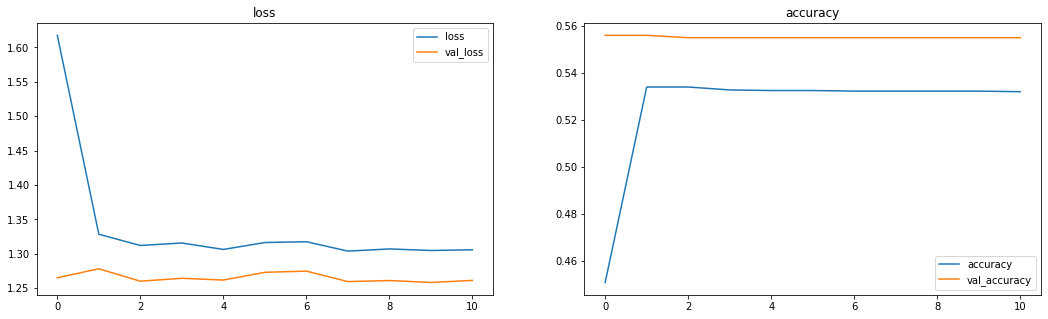

In [152]:
# Plot the learning curves and analyze them
babysit(history)

<font color="red">[ TO DO STUDENTS]</font>

Is your network learning? Check your intuition by evaluating your model and looking at the confusion matrix.

In [153]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded, batch_size=batch_size)

4/4 [==============================] - 0s 74ms/step - loss: 1.2634 - accuracy: 0.5560


In [154]:
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_accuracy)

Test Loss:  1.2634233236312866
Test Accuracy:  0.5559999942779541


32/32 [==============================] - 1s 14ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       159
           1       0.00      0.00      0.00        51
           2       0.00      0.00      0.00        71
           3       0.00      0.00      0.00       163
           4       0.56      1.00      0.71       556

    accuracy                           0.56      1000
   macro avg       0.11      0.20      0.14      1000
weighted avg       0.31      0.56      0.40      1000



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


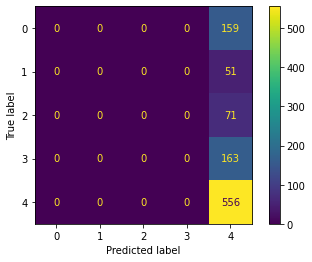

In [155]:
# Print/plot the confusion matrix
# Get predictions for test data
from keras.utils import to_categorical

y_pred = model.predict(X_test)
y_pred = np.round(y_pred)

y_test = np.argmax(y_test_encoded, axis=1)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

My network is not learning as it keeps predicting the same label all the time. This means that the network has a high bias and is underfitting the data so in the next steps we are going to increase the complexity of the network to see if we will have a better learning network.

### b) Experiment on ReLU activation

<font color="red">[ TO DO STUDENTS]</font>

Change activation from 'tanh' to 'relu', still with a deep network.

In [156]:
# Build a network with 30 hidden layers with 'tanh' activations
model = build_model(vectorizer, 'relu', 30, hidden_dim)

In [157]:
# Configure the model and start training
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train_encoded, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val_encoded), callbacks=callbacks_list)

Epoch 1/100
16/16 [==============================] - 5s 202ms/step - loss: 1.4117 - accuracy: 0.5140 - val_loss: 1.2580 - val_accuracy: 0.5560
Epoch 2/100
16/16 [==============================] - 3s 160ms/step - loss: 1.2778 - accuracy: 0.5340 - val_loss: 1.1563 - val_accuracy: 0.5560
Epoch 3/100
16/16 [==============================] - 3s 161ms/step - loss: 1.0682 - accuracy: 0.5590 - val_loss: 1.2242 - val_accuracy: 0.6400
Epoch 4/100
16/16 [==============================] - 3s 159ms/step - loss: 0.9709 - accuracy: 0.6783 - val_loss: 1.0014 - val_accuracy: 0.6350
Epoch 5/100
16/16 [==============================] - 3s 160ms/step - loss: 0.7744 - accuracy: 0.6977 - val_loss: 0.8886 - val_accuracy: 0.6670
Epoch 6/100
16/16 [==============================] - 3s 160ms/step - loss: 0.6431 - accuracy: 0.7180 - val_loss: 1.0239 - val_accuracy: 0.6790
Epoch 7/100
16/16 [==============================] - 3s 162ms/step - loss: 0.5369 - accuracy: 0.7697 - val_loss: 1.1583 - val_accuracy: 0.6200

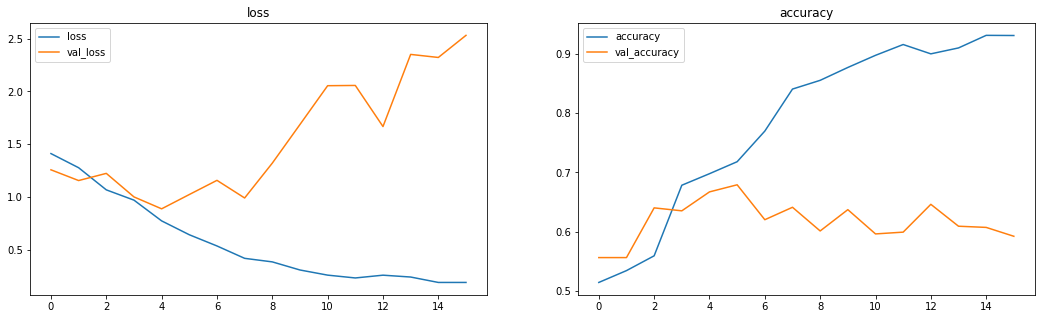

In [158]:
# Plot the learning curves and analyze them
babysit(history)

<font color="red">[ TO DO STUDENTS]</font>

Does the network learn better? Does the network perform well? Study the learning curves and justify your statements with the study of its performance (classification report and confusion matrix)

As the validation loss is obviously way higher than the loss we have an overfitting network.

On my code, it seems that the ReLU activation for sparsity has helped to solve the problem, but the model still struggles to learn and to get good performance on the validation set.

### c) Experiment on residual connections

<font color="red">[ TO DO STUDENTS ]<color>
* Create a function to generate models with residual connections.
* Using ReLU activation + residual connections, are you able to get better results ?
* Provide here a description of the learning and performances of your network
* Compare it to previous models. What are your conclusions ?

In [159]:
def build_residual_model(vectorizer, activation, n_hiddenlayers, hidden_dim):
    input_layer = keras.Input(shape=(1,), dtype=tf.string)
    x = vectorizer(input_layer)

    for i in range(n_hiddenlayers):
        residual = x
        x = layers.Dense(hidden_dim, activation=activation)(x)
        residual = layers.Dense(x.shape[1], activation=None)(residual)
        x = layers.add([x, residual])
    output_layer = layers.Dense(n_classes, activation='softmax')(x)
    model = keras.Model(inputs=input_layer, outputs=output_layer)
    return model

In [160]:
# Build a network with 30 hidden layers with 'relu' activations
model = build_residual_model(vectorizer, 'relu', 30, hidden_dim)

In [161]:
# Print and plot the model --> What is the best solution ?
# model.summary()

The plot model is better as it is easier to see visually as the model.summary is too complex to understand.

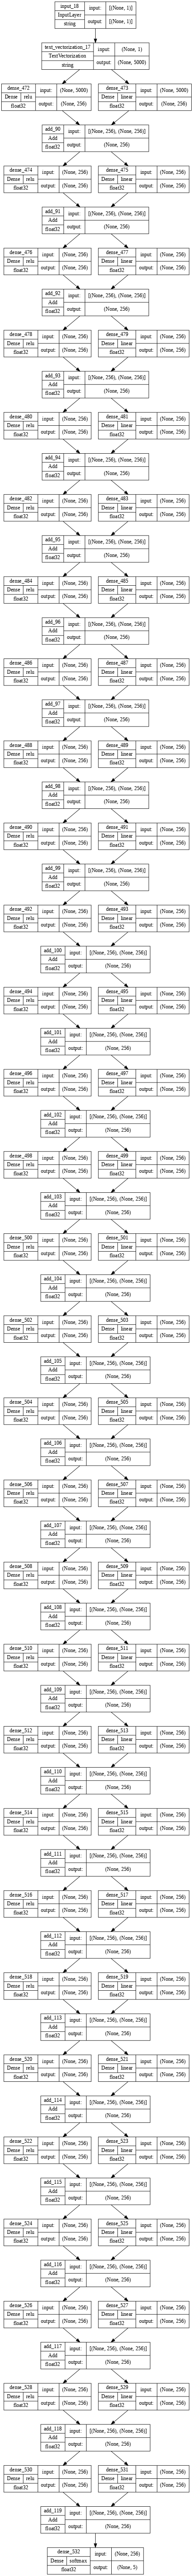

In [162]:
plot_model(model, show_shapes=True,
    show_dtype=True,
    #show_layer_names=True,
    #rankdir="TB",
    #expand_nested=True,
    dpi=64,
    #layer_range=True,
    show_layer_activations=True,
)

In [163]:
# Configure the model and start training
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train_encoded, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val_encoded), callbacks=callbacks_list)

Epoch 1/100
16/16 [==============================] - 9s 315ms/step - loss: 278.2492 - accuracy: 0.2707 - val_loss: 140.8784 - val_accuracy: 0.5560
Epoch 2/100
16/16 [==============================] - 4s 259ms/step - loss: 81.9358 - accuracy: 0.2962 - val_loss: 19.0253 - val_accuracy: 0.5030
Epoch 3/100
16/16 [==============================] - 4s 246ms/step - loss: 10.6815 - accuracy: 0.4078 - val_loss: 6.4108 - val_accuracy: 0.5350
Epoch 4/100
16/16 [==============================] - 4s 249ms/step - loss: 4.1797 - accuracy: 0.5117 - val_loss: 2.5775 - val_accuracy: 0.5310
Epoch 5/100
16/16 [==============================] - 4s 250ms/step - loss: 2.5887 - accuracy: 0.5583 - val_loss: 2.2451 - val_accuracy: 0.5120
Epoch 6/100
16/16 [==============================] - 4s 255ms/step - loss: 1.4260 - accuracy: 0.6440 - val_loss: 1.7293 - val_accuracy: 0.5760
Epoch 7/100
16/16 [==============================] - 4s 255ms/step - loss: 0.9253 - accuracy: 0.7205 - val_loss: 1.8293 - val_accuracy:

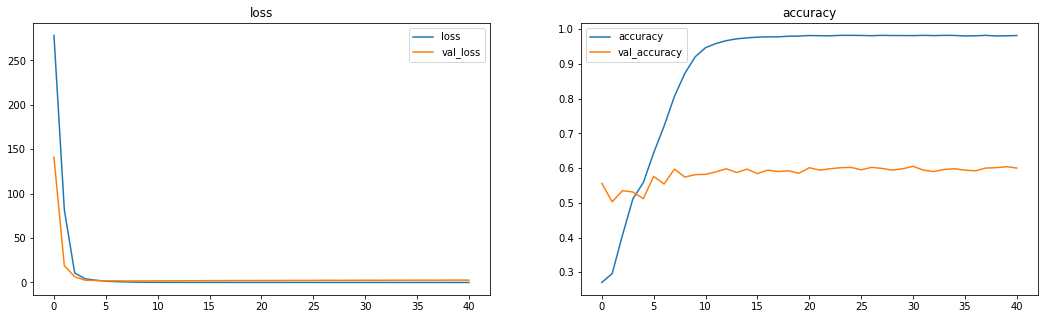

In [164]:
# Plot the learning curves and analyze them
babysit(history)

### d) Experiment on Batch Normalization

<font color="red">[ TO DO STUDENTS ]</font>
* step1: adapt build_model function to add batch normalization layers after the output of the hidden dense layers. 
* step2: adapt build_model function to use batch normalization layers and residuals
             
* In both case use ReLU activation and 30 hidden layers as previouly
* Compare your results

In [165]:
def build_model_batch_normalization(vectorizer, activation, n_hiddenlayers, hidden_dim):
    input_layer = keras.Input(shape=(1,), dtype=tf.string)
    x = vectorizer(input_layer)

    for i in range(n_hiddenlayers):
        x = layers.Dense(hidden_dim, activation=activation)(x)
        x = layers.BatchNormalization()(x)

    output_layer = layers.Dense(n_classes, activation='softmax')(x)
    model = keras.Model(inputs=input_layer, outputs=output_layer)
    return model

In [166]:
def build_residual_model_residual_batch_normalization(vectorizer, activation, n_hiddenlayers, hidden_dim):
    input_layer = keras.Input(shape=(1,), dtype=tf.string)
    x = vectorizer(input_layer)

    for i in range(n_hiddenlayers):
        residual = x
        x = layers.Dense(hidden_dim, activation=activation)(x)
        x = layers.BatchNormalization()(x)
        residual = layers.Dense(x.shape[1], activation=None)(residual)
        x = layers.add([x, residual])
        
    output_layer = layers.Dense(n_classes, activation='softmax')(x)
    model = keras.Model(inputs=input_layer, outputs=output_layer)
    return model

In [167]:
#Build and train the network with BatchNormalization layer
model = build_model_batch_normalization(vectorizer, 'relu', 30, hidden_dim)

# Configure the model and start training
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train_encoded, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val_encoded), callbacks=callbacks_list)

Epoch 1/100
16/16 [==============================] - 12s 253ms/step - loss: 1.9961 - accuracy: 0.2375 - val_loss: 1.4805 - val_accuracy: 0.5560
Epoch 2/100
16/16 [==============================] - 3s 183ms/step - loss: 1.7165 - accuracy: 0.3033 - val_loss: 1.3978 - val_accuracy: 0.5560
Epoch 3/100
16/16 [==============================] - 3s 183ms/step - loss: 1.5595 - accuracy: 0.3742 - val_loss: 1.3363 - val_accuracy: 0.5560
Epoch 4/100
16/16 [==============================] - 3s 179ms/step - loss: 1.4717 - accuracy: 0.4363 - val_loss: 1.2883 - val_accuracy: 0.5560
Epoch 5/100
16/16 [==============================] - 3s 178ms/step - loss: 1.4075 - accuracy: 0.4818 - val_loss: 1.2786 - val_accuracy: 0.5560
Epoch 6/100
16/16 [==============================] - 3s 209ms/step - loss: 1.3538 - accuracy: 0.5050 - val_loss: 1.2734 - val_accuracy: 0.5560
Epoch 7/100
16/16 [==============================] - 4s 218ms/step - loss: 1.3288 - accuracy: 0.5192 - val_loss: 1.2760 - val_accuracy: 0.556

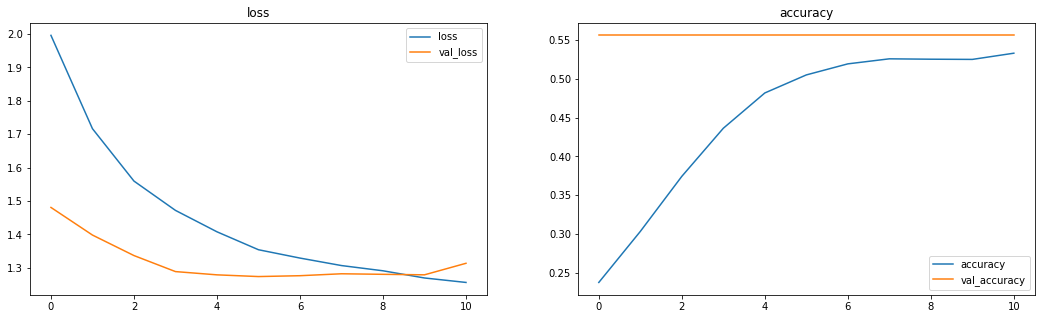

In [168]:
# Plot the learning curves and analyze them
babysit(history)

In [169]:
# Do the same with `build_residual_model_residual_batch_normalization`
model = build_residual_model_residual_batch_normalization(vectorizer, 'relu', 30, hidden_dim)

# Configure the model and start training
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train_encoded, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val_encoded), callbacks=callbacks_list)

Epoch 1/100
16/16 [==============================] - 15s 376ms/step - loss: 31.1678 - accuracy: 0.2560 - val_loss: 9.3246 - val_accuracy: 0.0690
Epoch 2/100
16/16 [==============================] - 4s 267ms/step - loss: 4.4885 - accuracy: 0.4795 - val_loss: 2.4199 - val_accuracy: 0.1460
Epoch 3/100
16/16 [==============================] - 4s 269ms/step - loss: 1.9343 - accuracy: 0.6008 - val_loss: 1.2402 - val_accuracy: 0.5970
Epoch 4/100
16/16 [==============================] - 4s 271ms/step - loss: 1.0587 - accuracy: 0.6835 - val_loss: 1.4724 - val_accuracy: 0.5590
Epoch 5/100
16/16 [==============================] - 4s 261ms/step - loss: 0.7114 - accuracy: 0.7635 - val_loss: 1.4640 - val_accuracy: 0.5770
Epoch 6/100
16/16 [==============================] - 4s 269ms/step - loss: 0.5358 - accuracy: 0.8175 - val_loss: 1.6069 - val_accuracy: 0.5640
Epoch 7/100
16/16 [==============================] - 4s 266ms/step - loss: 0.3396 - accuracy: 0.8790 - val_loss: 1.5429 - val_accuracy: 0.57

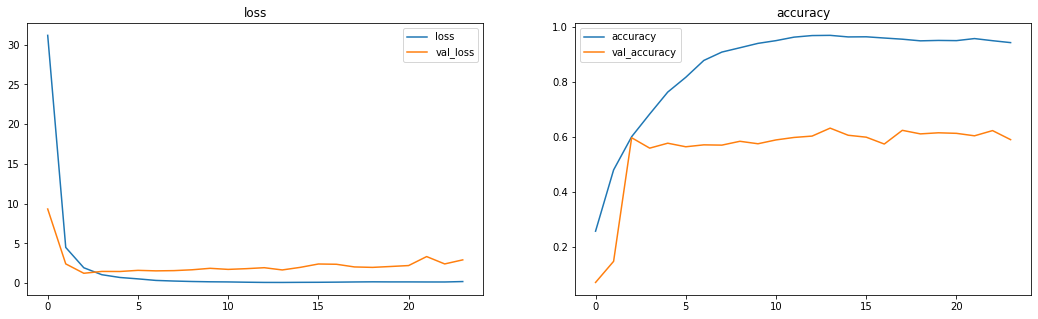

In [170]:
# Plot the learning curves and analyze them
babysit(history)

### e) What if you simply reduce the network depth ?

<font color="red">[ TO DO STUDENTS ]</font>
* build a MLP with ReLU activation composed of 10 hidden layers
* compare your results both in terms of learning and performances compared to other models

In [171]:
#Build and train the network without residual connections
model = build_model(vectorizer, 'relu', 10, hidden_dim)

In [172]:
# Configure the model and start training
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train_encoded, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val_encoded), callbacks=callbacks_list)

Epoch 1/100
16/16 [==============================] - 3s 142ms/step - loss: 1.3892 - accuracy: 0.5073 - val_loss: 1.1352 - val_accuracy: 0.5560
Epoch 2/100
16/16 [==============================] - 2s 111ms/step - loss: 1.0748 - accuracy: 0.5340 - val_loss: 0.9904 - val_accuracy: 0.5560
Epoch 3/100
16/16 [==============================] - 2s 111ms/step - loss: 0.8941 - accuracy: 0.6637 - val_loss: 0.9850 - val_accuracy: 0.6670
Epoch 4/100
16/16 [==============================] - 2s 111ms/step - loss: 0.7220 - accuracy: 0.7000 - val_loss: 0.9039 - val_accuracy: 0.6790
Epoch 5/100
16/16 [==============================] - 2s 106ms/step - loss: 0.5779 - accuracy: 0.7473 - val_loss: 0.9793 - val_accuracy: 0.5980
Epoch 6/100
16/16 [==============================] - 2s 108ms/step - loss: 0.4340 - accuracy: 0.8310 - val_loss: 1.3982 - val_accuracy: 0.5910
Epoch 7/100
16/16 [==============================] - 2s 110ms/step - loss: 0.2981 - accuracy: 0.8913 - val_loss: 1.7333 - val_accuracy: 0.6180

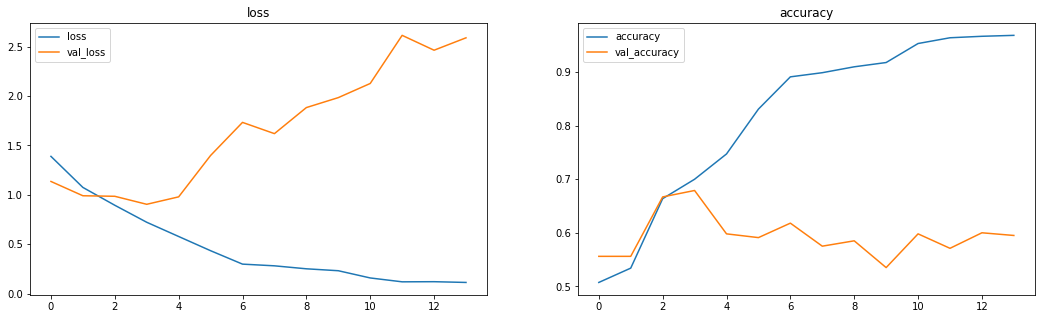

In [173]:
# Plot the learning curves and analyze them
babysit(history)

Normally, you observed a typical instance of overfitting.

## 4.  Underfitting and Overfitting problems

Actually what you observed in the last experiment is a typical instance of overfitting.

### a) Decrease the network size ?

In [174]:
#Build and train the network without residual connections
model = build_model(vectorizer, 'relu', 5, hidden_dim)

In [175]:
# Configure the model and start training
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train_encoded, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val_encoded), callbacks=callbacks_list)

Epoch 1/100
16/16 [==============================] - 3s 125ms/step - loss: 1.3745 - accuracy: 0.5063 - val_loss: 1.0810 - val_accuracy: 0.5560
Epoch 2/100
16/16 [==============================] - 2s 99ms/step - loss: 0.9528 - accuracy: 0.6425 - val_loss: 0.8888 - val_accuracy: 0.6690
Epoch 3/100
16/16 [==============================] - 2s 95ms/step - loss: 0.6766 - accuracy: 0.7172 - val_loss: 0.8560 - val_accuracy: 0.6810
Epoch 4/100
16/16 [==============================] - 2s 99ms/step - loss: 0.4610 - accuracy: 0.8240 - val_loss: 1.2040 - val_accuracy: 0.6550
Epoch 5/100
16/16 [==============================] - 2s 97ms/step - loss: 0.2895 - accuracy: 0.8982 - val_loss: 1.5108 - val_accuracy: 0.6410
Epoch 6/100
16/16 [==============================] - 2s 99ms/step - loss: 0.1848 - accuracy: 0.9423 - val_loss: 1.6815 - val_accuracy: 0.6500
Epoch 7/100
16/16 [==============================] - 2s 98ms/step - loss: 0.1397 - accuracy: 0.9580 - val_loss: 2.0203 - val_accuracy: 0.6290
Epoch

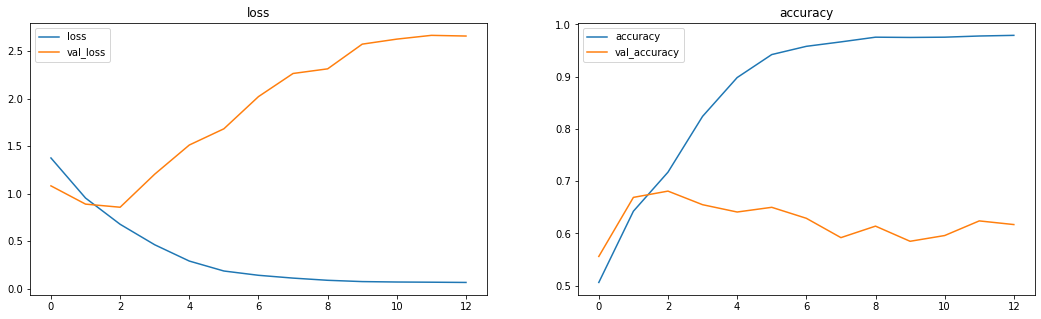

In [176]:
# Plot the learning curves and analyze them
babysit(history)

For me: it gets slightly better but almost the same behavior is observed when taking 10 and 5 hidden layers.

What's going on for you ?

Changing the network size smoothed the loss a little with a better and less chaotic behaviour but not much changed from the 10 layer network.

### b) Experiment on L2 regularization

<font color="red">[ TO DO STUDENTS ]</font>
* check the keras documentation on regularizations https://keras.io/api/layers/regularizers/
* Add to the previous network L2 regularization: first with l2_reg = 0.01 / then with l2_reg= 0.0001
* Compare results

In [177]:
# Design the model function
from tensorflow.keras import regularizers

def build_model_reg(vectorizer, activation, n_hiddenlayers, hidden_dim, l2_reg):
    input_layer = keras.Input(shape=(1,), dtype=tf.string)
    x = vectorizer(input_layer)

    for i in range(n_hiddenlayers):
        x = layers.Dense(hidden_dim, activation=activation, 
                        kernel_regularizer=keras.regularizers.l2(l2_reg), 
                        bias_regularizer=keras.regularizers.l2(l2_reg))(x)

    output_layer = layers.Dense(n_classes, activation='softmax')(x)
    model = keras.Model(inputs=input_layer, outputs=output_layer)
    return model

In [178]:
#Build and train the network without residual connections
model = build_model_reg(vectorizer, 'relu', 5, hidden_dim, 0.01)


In [179]:
# Configure the model and start training
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train_encoded, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val_encoded), callbacks=callbacks_list)

Epoch 1/100
16/16 [==============================] - 3s 133ms/step - loss: 12.4604 - accuracy: 0.5150 - val_loss: 8.5923 - val_accuracy: 0.5560
Epoch 2/100
16/16 [==============================] - 2s 102ms/step - loss: 6.7975 - accuracy: 0.5340 - val_loss: 5.1204 - val_accuracy: 0.5560
Epoch 3/100
16/16 [==============================] - 2s 107ms/step - loss: 4.2634 - accuracy: 0.5443 - val_loss: 3.3984 - val_accuracy: 0.6440
Epoch 4/100
16/16 [==============================] - 2s 108ms/step - loss: 2.8757 - accuracy: 0.6513 - val_loss: 2.3822 - val_accuracy: 0.6560
Epoch 5/100
16/16 [==============================] - 2s 106ms/step - loss: 2.0455 - accuracy: 0.6755 - val_loss: 1.8011 - val_accuracy: 0.6730
Epoch 6/100
16/16 [==============================] - 2s 103ms/step - loss: 1.5731 - accuracy: 0.6848 - val_loss: 1.4722 - val_accuracy: 0.6660
Epoch 7/100
16/16 [==============================] - 2s 102ms/step - loss: 1.2917 - accuracy: 0.6942 - val_loss: 1.2946 - val_accuracy: 0.672

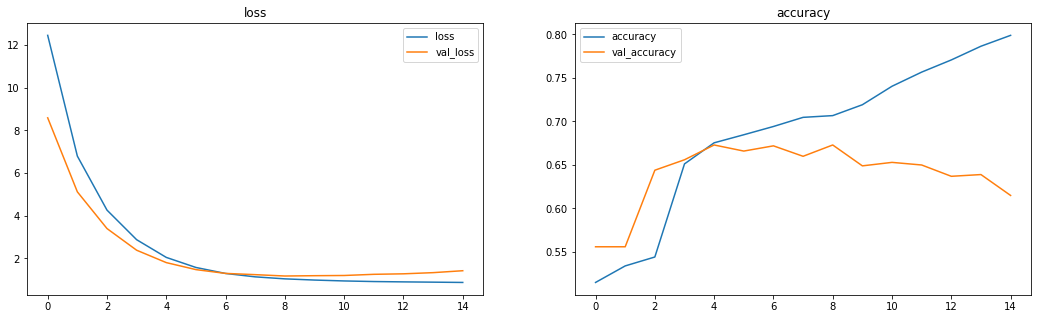

In [180]:
# Plot the learning curves and analyze them
babysit(history)

<font color="red">[ TO DO STUDENTS]

Reduce the coefficient of L2 regularization taken into account in the loss from l2_reg = 0.01 > to l2_reg = 0.0001 and do the same experimentation.

In [181]:
model = build_model_reg(vectorizer, 'relu', 5, hidden_dim, 0.0001)

In [182]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train_encoded, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val_encoded), callbacks=callbacks_list)

Epoch 1/100
16/16 [==============================] - 3s 135ms/step - loss: 1.5038 - accuracy: 0.5105 - val_loss: 1.2069 - val_accuracy: 0.5580
Epoch 2/100
16/16 [==============================] - 2s 105ms/step - loss: 1.0820 - accuracy: 0.6327 - val_loss: 0.9900 - val_accuracy: 0.6850
Epoch 3/100
16/16 [==============================] - 2s 104ms/step - loss: 0.7846 - accuracy: 0.7175 - val_loss: 0.9868 - val_accuracy: 0.6840
Epoch 4/100
16/16 [==============================] - 2s 106ms/step - loss: 0.5794 - accuracy: 0.8123 - val_loss: 1.2056 - val_accuracy: 0.6790
Epoch 5/100
16/16 [==============================] - 2s 103ms/step - loss: 0.3961 - accuracy: 0.8978 - val_loss: 1.6533 - val_accuracy: 0.6490
Epoch 6/100
16/16 [==============================] - 2s 102ms/step - loss: 0.2943 - accuracy: 0.9337 - val_loss: 1.9903 - val_accuracy: 0.6470
Epoch 7/100
16/16 [==============================] - 2s 107ms/step - loss: 0.2536 - accuracy: 0.9477 - val_loss: 2.1878 - val_accuracy: 0.6460

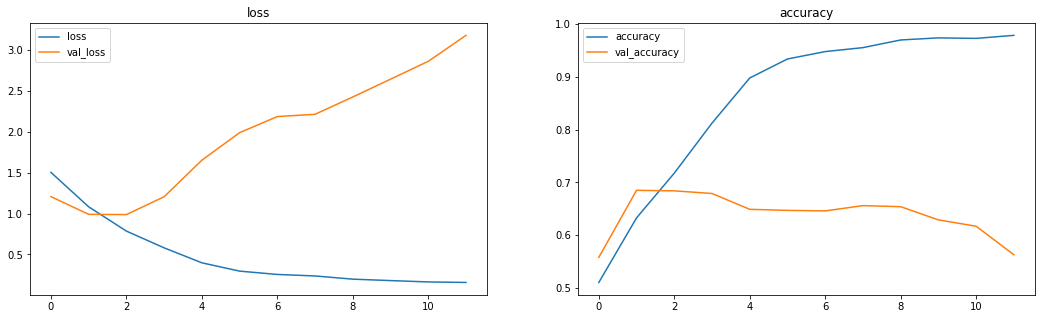

In [183]:
babysit(history)

What is your conclusion ?

Here we are trying to reduce the overfitting adding a penalty to the loss function.

When l2_reg is set to a 0.1, it means a higher penalty is added to the loss function, which results in a model that is less complex and has lower variance so less prone to overfitting.

When l2_reg is set to 0.0001, the model that is more complex and has higher variance so more prone to overfitting

So, decreasing l2_reg from 0.1 to 0.0001 is expected to lead to a more complex model that has higher variance.

### c) Experiment on Dropout

<font color="red">[TO DO STUDENTS]</font>
* Observe the provided results for a dropout ratio of p=0.7 and p=0.3
* What are your conclusions ?
* In the end, considering all the explored settings in this Lab, what would you suggest as a network to get a better model ?

In [184]:
# Design the model function
from keras.layers import Dropout

def build_model_dropout(vectorizer, activation, n_hiddenlayers, hidden_dim, p = 0.7):
    input_layer = keras.Input(shape=(1,), dtype=tf.string)
    x = vectorizer(input_layer)

    for i in range(n_hiddenlayers):
        x = layers.Dense(hidden_dim, activation=activation)(x)
        x = Dropout(p)(x)

    output_layer = layers.Dense(n_classes, activation='softmax')(x)
    model = keras.Model(inputs=input_layer, outputs=output_layer)
    return model

In [185]:
# Build and train the network without residual connections
model = build_model_dropout(vectorizer, 'relu', 5, hidden_dim, 0.7)

In [186]:
# Configure the model and start training
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train_encoded, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val_encoded), callbacks=callbacks_list)

Epoch 1/100
16/16 [==============================] - 3s 132ms/step - loss: 1.5088 - accuracy: 0.4678 - val_loss: 1.4447 - val_accuracy: 0.5560
Epoch 2/100
16/16 [==============================] - 2s 100ms/step - loss: 1.3931 - accuracy: 0.5303 - val_loss: 1.3643 - val_accuracy: 0.5560
Epoch 3/100
16/16 [==============================] - 2s 101ms/step - loss: 1.3295 - accuracy: 0.5335 - val_loss: 1.2854 - val_accuracy: 0.5560
Epoch 4/100
16/16 [==============================] - 2s 99ms/step - loss: 1.2840 - accuracy: 0.5328 - val_loss: 1.2533 - val_accuracy: 0.5560
Epoch 5/100
16/16 [==============================] - 2s 99ms/step - loss: 1.2259 - accuracy: 0.5337 - val_loss: 1.1988 - val_accuracy: 0.5560
Epoch 6/100
16/16 [==============================] - 2s 102ms/step - loss: 1.1731 - accuracy: 0.5340 - val_loss: 1.1727 - val_accuracy: 0.5560
Epoch 7/100
16/16 [==============================] - 2s 100ms/step - loss: 1.0889 - accuracy: 0.5335 - val_loss: 1.1195 - val_accuracy: 0.5560
E

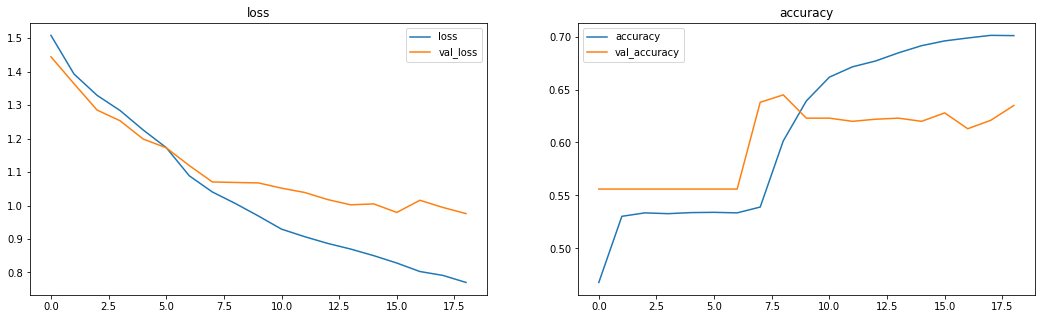

In [187]:
babysit(history)

<font color="red">[ TO DO STUDENTS]

Decrease the proportion of neurons deactivated at each forward pass, from 0.7 to 0.3

In [188]:
model = build_model_dropout(vectorizer, 'relu', 5, hidden_dim, 0.3)

In [189]:
# Configure the model and start training
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train_encoded, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val_encoded), callbacks=callbacks_list)

Epoch 1/100
16/16 [==============================] - 3s 127ms/step - loss: 1.4129 - accuracy: 0.5085 - val_loss: 1.1694 - val_accuracy: 0.5560
Epoch 2/100
16/16 [==============================] - 2s 101ms/step - loss: 1.1306 - accuracy: 0.5347 - val_loss: 1.0166 - val_accuracy: 0.5890
Epoch 3/100
16/16 [==============================] - 2s 102ms/step - loss: 0.9365 - accuracy: 0.6425 - val_loss: 0.9050 - val_accuracy: 0.6730
Epoch 4/100
16/16 [==============================] - 2s 100ms/step - loss: 0.7430 - accuracy: 0.7070 - val_loss: 0.9093 - val_accuracy: 0.6830
Epoch 5/100
16/16 [==============================] - 2s 100ms/step - loss: 0.5999 - accuracy: 0.7595 - val_loss: 0.9795 - val_accuracy: 0.6490
Epoch 6/100
16/16 [==============================] - 2s 99ms/step - loss: 0.4751 - accuracy: 0.8202 - val_loss: 1.2005 - val_accuracy: 0.6620
Epoch 7/100
16/16 [==============================] - 2s 100ms/step - loss: 0.3769 - accuracy: 0.8568 - val_loss: 1.3363 - val_accuracy: 0.6400


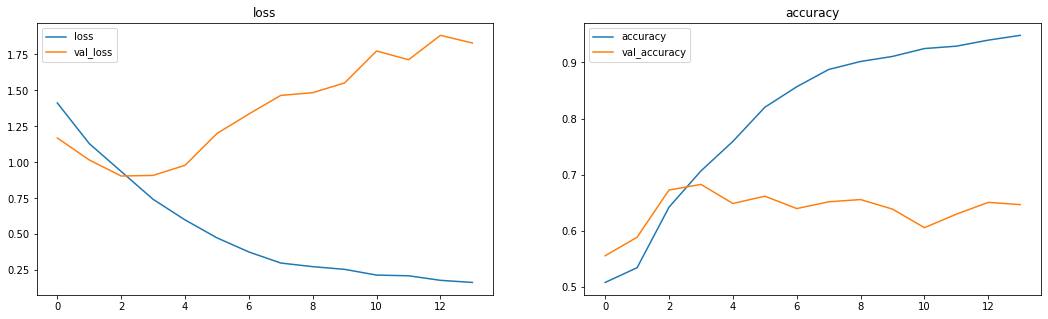

In [190]:
babysit(history)

What is your conclusion ?

Our model is overall is overfitting. And the dropout p value represents the fraction of activations in layers that are set to zero when training the model. So when we choose a high value of p like 0.7 it can prevent the model from memorizing the data as it set many activations to zeros. 
And by giving the p a value of 0.3 may still help the model overfit as smaller fraction of activations are drop out so there is more model capacity.  

## Stop and resume training

Learning how to start, stop and resume learning a deep learning model is a very important skill to master. At some point:

* You have limited time on a GPU instance (this can happen on Google Colab or when using the cheaper Amazon EC2 point instances).
* Your SSH connection is broken.
* Your deep learning platform crashes and shuts down.

Imagine you've spent a whole week training a state-of-the-art deep neural network... and your model is lost due to a power failure! Fortunately, there is a solution - but when these situations occur, you need to know what to do:

1. Take a snapshot model that was saved/serialized to disk during training.
1. Load the model into memory.
1. Resume training where you left off.

Starting, stopping and resuming training is standard practice when setting the learning rate manually:

1. Start training your model until the loss/accuracy reaches a plateau.
1. Take a snapshot of your model every N epochs (typically N={1, 5, 10})
1. Stop training when you arrive at a plateau (by forcing out via ctrl + c or via earlystopping
1. Adjust your learning rate (typically by reducing it by an order of magnitude).
1. Restart the training script, starting from the last snapshot of the model weights

The ability to adjust the learning rate is an essential skill for any deep learning practitioner to master, so take the time to study and practice it!

<font color="red">Look at the documentation Tensorflow has proposed for ModelCheckpoint: we want to save the model at the end of each epoch so that we can restore it later.</font>

In [201]:
# Reuse one the previous model and reset it
# Use sgd as optimizer and fix learning_rate = 0.1
# Use 2 callbacks : EarlyStopping and ModelCheckpoint
# Save model at each epoch
# Fit the network
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

model = build_model_dropout(vectorizer, 'relu', 5, hidden_dim, 0.5)

opt = optimizers.SGD(learning_rate=0.1) # Fix learning rate to 0.1
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

callbacks_list = [EarlyStopping(monitor='val_accuracy', mode='max',
                                patience=patience,
                                restore_best_weights=True),
                  ModelCheckpoint(filepath=r'C:\Users\Admin\Desktop\UCA-2023\Deep_Learning\best_weights',
                                  save_best_only=True,
                                  save_weights_only=True,
                                  save_format='tf'
                                 )]
history1 = model.fit(X_train, y_train_encoded, validation_data=(X_val, y_val_encoded),
                    epochs=epochs, batch_size=batch_size, callbacks=callbacks_list, verbose=1)

Epoch 1/100
16/16 [==============================] - 6s 252ms/step - loss: 1.4574 - accuracy: 0.4925 - val_loss: 1.3084 - val_accuracy: 0.5560
Epoch 2/100
16/16 [==============================] - 3s 199ms/step - loss: 1.3201 - accuracy: 0.5343 - val_loss: 1.2663 - val_accuracy: 0.5560
Epoch 3/100
16/16 [==============================] - 3s 178ms/step - loss: 1.3056 - accuracy: 0.5335 - val_loss: 1.2546 - val_accuracy: 0.5560
Epoch 4/100
16/16 [==============================] - 2s 99ms/step - loss: 1.2923 - accuracy: 0.5335 - val_loss: 1.2468 - val_accuracy: 0.5560
Epoch 5/100
16/16 [==============================] - 2s 97ms/step - loss: 1.2866 - accuracy: 0.5328 - val_loss: 1.2400 - val_accuracy: 0.5560
Epoch 6/100
16/16 [==============================] - 2s 95ms/step - loss: 1.2801 - accuracy: 0.5328 - val_loss: 1.2319 - val_accuracy: 0.5560
Epoch 7/100
16/16 [==============================] - 2s 134ms/step - loss: 1.2709 - accuracy: 0.5310 - val_loss: 1.2209 - val_accuracy: 0.5560
Ep

In [ ]:
# Re-load the model
new_model = tf.keras.models.load_model(...)

What is the difference between load_model and load_weights ?

In [ ]:
# Change learning_rate = 0.01
new_model.optimizer.lr.assign(0.01)

In [ ]:
# Continue to fit the network
history2 = new_model.fit(X_train, y_train_encoded, validation_data=(X_val, y_val_encoded),
                    epochs=epochs, batch_size=batch_size, callbacks=callbacks_list, verbose=0)

## Use Keras-tuner

<font color="red">[TO DO STUDENTS]</font>

From the previous experiences use Keras-tuner to find the best possible network.

Keras-Tuner must build at least 3 different network architectures:
* Dense cells only
* Addition of residuals
* Adding batch normalisation
* Adding dropout
* A combination of the different additions


In [206]:
!pip install --upgrade keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [209]:
import tensorflow as tf
import kerastuner as kt
from kerastuner.engine.hyperparameters import HyperParameters

def build_model(hp):
    input_layer = tf.keras.Input(shape=(1,), dtype=tf.string)
    x = vectorizer(input_layer)

    for i in range(hp.Int('n_hiddenlayers', 2, 30)):
        x = tf.keras.layers.Dense(hp.Int('hidden_dim', 32, 512, 32), activation=hp.Choice('activation', ['relu', 'tanh']))(x)
        
        if hp.Choice('normalization', ['batch_normalization', 'none']) == 'batch_normalization':
            x = tf.keras.layers.BatchNormalization()(x)
        
        if hp.Choice('dropout', ['yes', 'no']) == 'yes':
            x = tf.keras.layers.Dropout(hp.Float('dropout_rate', 0.2, 0.5, step=0.1))(x)
        
        if hp.Choice('residual', ['yes', 'no']) == 'yes':
            residual = x
            x = tf.keras.layers.Dense(x.shape[1], activation=None)(residual)
            x = tf.keras.layers.add([x, residual])

    output_layer = tf.keras.layers.Dense(n_classes, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = kt.Hyperband(build_model,
                     objective='val_accuracy', 
                     max_epochs=100,
                     factor=3,
                     directory=r'C:\Users\Admin\Desktop\UCA-2023\Deep_Learning\Week2-More_on_MLP',
                     project_name='MLP_amazon')

tuner.search(X_train, y_train_encoded, epochs=100, validation_data=(X_val, y_val_encoded))


best_model = tuner.get_best_models()
# best_model = tuner.get_best_models(num_models=1)[0]


Trial 100 Complete [00h 00m 01s]

Best val_accuracy So Far: 0.6869999766349792
Total elapsed time: 00h 34m 08s

Search: Running Trial #101

Value             |Best Value So Far |Hyperparameter
11                |6                 |n_hiddenlayers
416               |288               |hidden_dim
tanh              |relu              |activation
none              |none              |normalization
yes               |no                |dropout
0.2               |0.2               |dropout_rate
no                |no                |residual
0.0001242         |0.00042169        |learning_rate
4                 |2                 |tuner/epochs
2                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
1                 |0                 |tuner/round
0004              |None              |tuner/trial_id



Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/keras_tuner/engine/base_tuner.py", line 250, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.8/dist-packages/keras_tuner/engine/base_tuner.py", line 215, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.8/dist-packages/keras_tuner/tuners/hyperband.py", line 401, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.8/dist-packages/keras_tuner/engine/tuner.py", line 284, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.8/dist-packages/keras_tuner/engine/tuner.py", line 210, in _build_and_fit_model
    model = self._try_build(hp)
  File "/usr/local/lib/python3.8/dist-packages/keras_tuner/engine/tuner.py", line 152, in _try_build
    model = self._bui

RuntimeError: ignored

<font color="red">I tried multiple times and at some point it stopped and failed tuning the model.</font>

But I was getting some results in the middle of tuning.